In [ ]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics
from sklearn import feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns


import gensim
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
## for bert language model
#import transformers
import nltk

nltk.download('all')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_da

True

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/train_data.csv')
train_X_Path = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle/train_data.csv"
train_Y_Path = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle/train_results.csv"
test_X_Path = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle/test_data.csv"

In [ ]:
# Training data
df = pd.read_csv(train_X_Path)
# Dropping id column
df.drop(['id'],axis=1,inplace=True)
# Training labels
df_train_Y = pd.read_csv(train_Y_Path)
df_train_Y.head()
# Dropping id column
df_train_Y = df_train_Y.drop(columns=['id'],axis=1)
# Converting categorical labels to numeric
df_train_Y.target[df_train_Y.target == 'positive'] = 2
df_train_Y.target[df_train_Y.target == 'negative'] = 0
df_train_Y.target[df_train_Y.target == 'neutral'] = 1
# combining text data and labels to one single dataframe
df = pd.concat([df,df_train_Y],axis=1)

In [ ]:
# Text Clean-Up

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=  text.strip()  
    text=  re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Removes url
    text = re.compile(r'<[^>]+>').sub('', text) #Removes HTML tags:
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Single character removal
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    return text

# STOPWORD REMOVAL
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
def remove_stopwords(str):
    return " ".join([word for word in str.split() if word not in stop])

# Clean text without stop words removal
df['clean_text'] = df['text'].map(lambda x: preprocess(x))
#df['clean_text'] = df['clean_text'].map(lambda x: remove_stopwords(x))

# Checking the status of clean text with stop words removed
df['clean_text_len'] = df['clean_text'].apply(lambda x:len(str(x).split()))
print(df['clean_text_len'].sum())
df['clean_text_len'].describe()
# removing samples with zero words
no_text = df[df['clean_text_len']==0]
df.drop(no_text.index,inplace=True)


13156702


In [ ]:
new_df = df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
 
new_df.columns = ['Word', 'Frequency']

new_df


,Word,Frequency
0,to,368371
1,the,341615
2,my,206635
3,it,198104
4,and,197391
...,...,...
450421,michey,1
450422,tudumo,1
450423,faitaccompli,1
450424,wnpn,1


In [ ]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
df['tokens'] = df['clean_text'].apply(lambda x:tokenizer.tokenize(x))
df.head()

,text,target,clean_text,clean_text_len,tokens
0,Anyway Im getting of for a while,2,anyway im getting of for while,6,"[anyway, im, getting, of, for, while]"
1,"My red, Apache isn't feelin too well this morn...",0,my red apache isn feelin too well this morning...,12,"[my, red, apache, isn, feelin, too, well, this..."
2,@danyelljoy you should be its great. friday w...,2,danyelljoy you should be its great friday will...,11,"[danyelljoy, you, should, be, its, great, frid..."
3,its 11:30pm and i dont wanna sleep; so i debat...,2,its pm and dont wanna sleep so debated with my...,22,"[its, pm, and, dont, wanna, sleep, so, debated..."
4,Why does twitter eat my DM's? Not happy,0,why does twitter eat my dm not happy,8,"[why, does, twitter, eat, my, dm, not, happy]"


In [ ]:
import gensim

In [ ]:
# Label Encoding
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'target'.
df['target']= label_encoder.fit_transform(df['target'])
y = df['target']

X = df['clean_text']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 42)


In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = df['clean_text_len'].max()
#max_features = int(new_df.shape[0]/2)
max_features = 50000

In [ ]:
def Token_padding(data_train, data_test):

  Tokens = Tokenizer(num_words = max_features, oov_token ='OOV')
  Tokens.fit_on_texts(data_train)
  #vocab_size = len(Tokens.word_index) + 1
  encd_rev_train = Tokens.texts_to_sequences(data_train)
  pad_sent_train = pad_sequences(encd_rev_train, maxlen=max_len, padding='post')

  encd_rev_test = Tokens.texts_to_sequences(data_test)
  pad_sent_test = pad_sequences(encd_rev_test, maxlen=max_len, padding='post')

  return pad_sent_train, pad_sent_test

In [ ]:
X_train_vector,  X_valid_vector = Token_padding(X_train, X_valid)

Y_train = pd.get_dummies(y_train).values
Y_valid = pd.get_dummies(y_valid).values

print(X_train_vector.shape, X_valid_vector.shape, Y_train.shape,Y_valid.shape)

(832258, 116) (208065, 116) (832258, 3) (208065, 3)


In [ ]:
import tensorflow as tf

embed_dim = 300

model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_LSTM.summary()

opt = keras.optimizers.RMSprop(learning_rate=0.001)
model_LSTM.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100
batch_size = 128

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=5, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True)
history = model_LSTM.fit(X_train_vector, Y_train, 
                    epochs = epochs, 
                    batch_size=batch_size,
                    validation_data = (X_valid_vector, Y_valid),
                    shuffle = True,
                    callbacks=[es])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 300)          15000000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

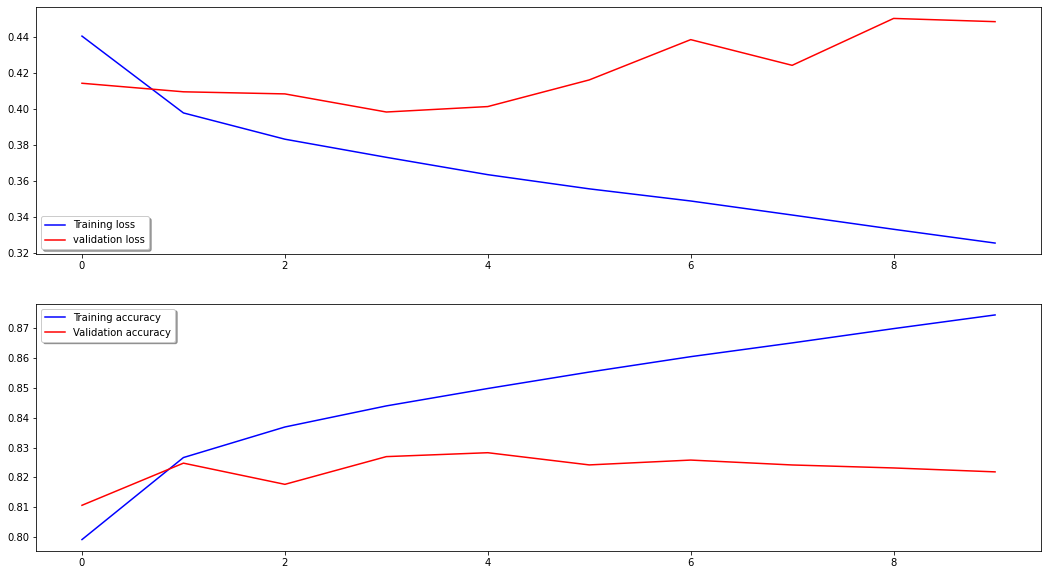

<Figure size 720x720 with 0 Axes>

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

fig = plt.figure(figsize=(10, 10)) # Set Figure

In [ ]:
df_test_X = pd.read_csv(test_X_Path)
df_test_X.head()

,id,text
0,0,so cut... missed out on all the TCE EXTREME ME...
1,1,Thank you very much Wasin this is awesome lol
2,2,Squeezing in some internet time before Dustin ...
3,3,@fanoou; Oh i do have moral but i'm gonna be b...
4,4,@NSuissa I just bought Sammy some joint/hip ...


In [ ]:

df_test_X.shape

(560175, 2)

In [ ]:

df_test_X = df_test_X.drop(columns=['id'],axis=1)
df_test_X.head()

,text
0,so cut... missed out on all the TCE EXTREME ME...
1,Thank you very much Wasin this is awesome lol
2,Squeezing in some internet time before Dustin ...
3,@fanoou; Oh i do have moral but i'm gonna be b...
4,@NSuissa I just bought Sammy some joint/hip ...


In [ ]:
# Clean text without stop words removal
df_test_X['clean_text'] = df_test_X['text'].map(lambda x: preprocess(x))
df_test_X.head()

,text,clean_text
0,so cut... missed out on all the TCE EXTREME ME...,so cut missed out on all the tce extreme merch...
1,Thank you very much Wasin this is awesome lol,thank you very much wasin this is awesome lol
2,Squeezing in some internet time before Dustin ...,squeezing in some internet time before dustin ...
3,@fanoou; Oh i do have moral but i'm gonna be b...,fanoou oh do have moral but m gonna be bigger ...
4,@NSuissa I just bought Sammy some joint/hip ...,nsuissa just bought sammy some joint hip suppl...


In [ ]:

# tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
# df_test_X['tokens'] = df_test_X['clean_text'].apply(lambda x:tokenizer.tokenize(x))
X_test = df_test_X['clean_text']
X_train_vector,  X_test_vector = Token_padding(X_train, X_test)



In [ ]:
# df_test_X_padded = pad_sequences(encd_rev_test, maxlen=max_len)
pred = model_LSTM.predict(X_test_vector)

pred

17506/17506 [==============================] - 114s 6ms/step


array([[9.0958220e-01, 0.0000000e+00, 9.0417847e-02],
       [1.3954627e-02, 0.0000000e+00, 9.8604530e-01],
       [5.4267842e-01, 5.1230012e-17, 4.5732161e-01],
       ...,
       [9.9625742e-01, 0.0000000e+00, 3.7426015e-03],
       [6.7774022e-01, 0.0000000e+00, 3.2225978e-01],
       [1.7317753e-01, 0.0000000e+00, 8.2682252e-01]], dtype=float32)

In [ ]:
#

In [ ]:
list_index = list(df_test_X.index.values)

y_pred_list = []
for i in range(df_test_X.shape[0]):
  y_pred_list.append(np.argmax(pred[i]))
y_pred_list

out = pd.DataFrame({'id': list_index,'target':y_pred_list})
filename = 'RNN_LSTM_Tokenization_corrected_V2.csv'
out



,id,target
0,0,0
1,1,2
2,2,0
3,3,2
4,4,0
...,...,...
560170,560170,0
560171,560171,0
560172,560172,0
560173,560173,0


In [ ]:
out.to_csv(filename, index=False)
print('Saved file: ' + filename)

Saved file: RNN_LSTM_Tokenization_corrected_V2.csv


In [ ]:
out.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Kaggle/rnn_lstm_best_model_seed42.csv", index=False)

In [ ]:
#

In [ ]:
#